# Initialize table and data from file

In [13]:
# initialize data 
###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name,case):
    #case = 1-> Id from file. Iq in 0->220 > 'i_direct_flux'
    #case = 2 -> Iq from file. Id in 0->220 > 'j_q_flux'
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(220, -1, -20))
    if case == 1:
        xLabel = 'd-axis current - Id [A]'
        yLabel = 'Direct flux linkage [Wb]'
        Is = 'Iq '
    elif case == 2:
        xLabel = 'q-axis current -Iq [A]'
        yLabel = 'Quadratic flux [Wb]'  
        Is = 'Id'
    return ids, dfs, iqs, xLabel, yLabel, Is


ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux',1 )


# Plot all original Iq curves

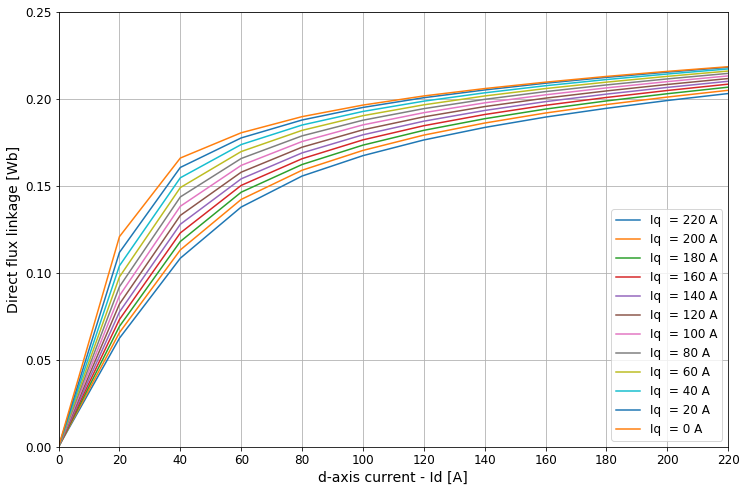

In [6]:
#
plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12


for idx in range(0, 12):
    df = dfs[:, idx]
    plt.plot(ids, df, label='%s = %d A' %(Is,iqs[idx]))
    plt.ylim([0, 0.25])
    plt.xlim([0, 220])
    plt.xticks(ids)
    plt.xlabel(xLabel, fontsize = 14)
    plt.ylabel(yLabel, fontsize = 14)
    plt.legend(loc='best', fontsize = 12)
plt.grid()
plt.savefig('OriginalIqs.png', dpi = 200)
plt.show()

# PCA for reducing the number of Iq curves


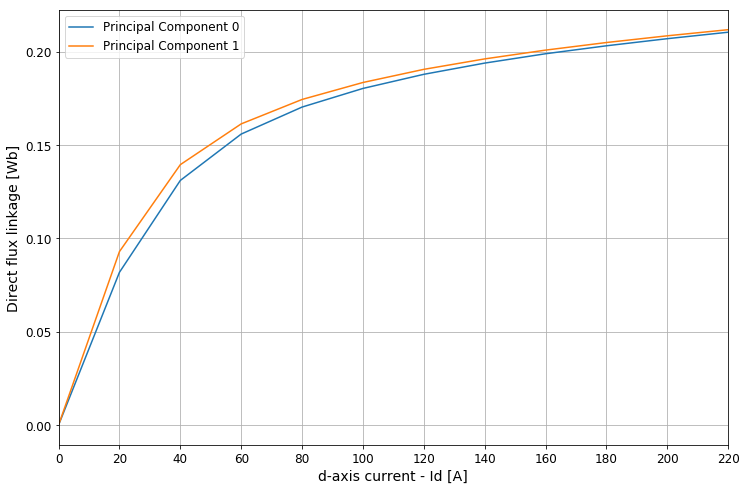

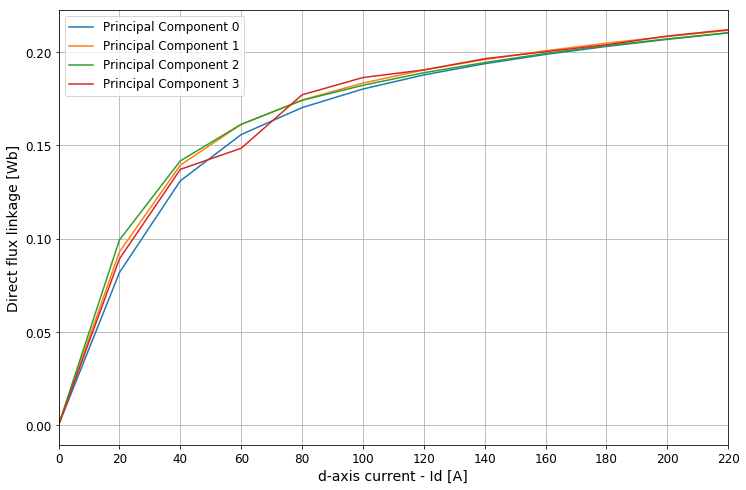

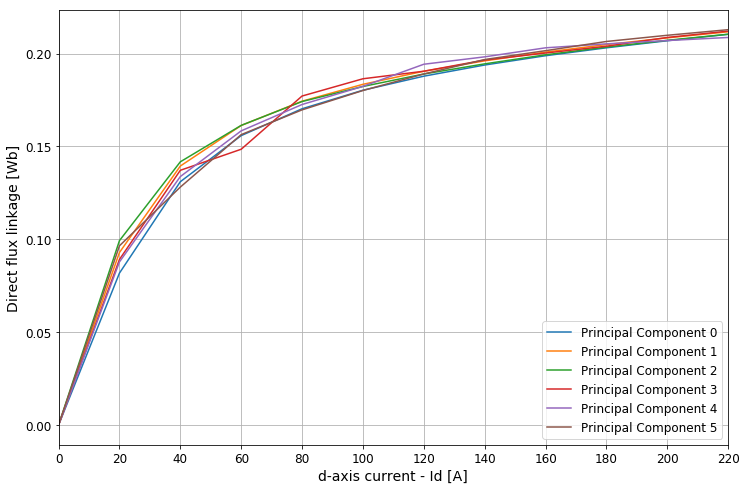

In [7]:
#
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing


#INITIALIZE THE TABLE 
headers =[ 'No of PCs' ]+['Total Error'] + ['Id %d'%id for id in ids] 
rows    = []

#preprocess the data
flux = dfs.T
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(flux)

avg_Iqs_weights_headers = ['Components'] + ['Iq %d' % iq for iq in ids]
avg_Iqs_weights_rows = []

no_of_comps = [2, 4, 6]
for comp in no_of_comps:
    row = [comp]
    pca_reduce_curves = PCA(n_components=comp)
    flux_reduced = pca_reduce_curves.fit_transform(df_flux_scaled)
    projected  = pca_reduce_curves.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)

    # # plot reconstructions
    # for curve in range(0, flux.shape[0], 4):
    #     plt.clf()
#         plt.rcParams["figure.figsize"] = [12,8]
#         plt.rcParams['xtick.labelsize']=12
#         plt.rcParams['ytick.labelsize']=12
    #     plt.plot(x_new, flux[curve, :], label = 'original', color = 'black')
    #     plt.plot(x_new, projected_unscaled[curve, :], label = 'projected')
    #     plt.legend()
    #     plt.title('IQ: %d pca_comp: %d' % (iqs[curve], comp))
    #     plt.grid()
    #     plt.show() 

    
    # plot main components
    plt.clf()
    plt.rcParams["figure.figsize"] = [12,8]
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    
    components = pca_reduce_curves.components_
    components = scaler.inverse_transform(components)
    
    for idx in range(components.shape[0]):
        plt.plot(ids, components[idx, :], label='Principal Component %d'%idx)
        plt.xlabel(xLabel,fontsize=14)
        plt.ylabel(yLabel,fontsize=14)
        plt.legend(fontsize=12)  
        plt.xticks(list(range(0, 240, 20)))
        plt.xlim(0, 220)
    plt.grid()
    plt.savefig('TOP{}PrincipalComponents.png'.format(comp), dpi = 200)  
    plt.show() 
    
    error = (flux - projected_unscaled) ** 2
    error = np.sum(error, axis=1)
    error = error.astype(np.float64) * (10 ** 6)
    row.append(sum(error))
    row = row + error.tolist() 
    
    rows.append(row)
    
    #table - meaning of PCs  
    headers_PC =[ 'Idx of PC' ] + ['Iq %d' % id for id in ids] 
    rows_PC    = []
    i = 1
    for component in pca_reduce_curves.components_:
        row_PC = [i]
        for value in component:
            row_PC.append(value)
        i+=1
        rows_PC.append(row_PC)
        
    # average contribution of each feature
    avg_weights = np.mean(abs(pca_reduce_curves.components_), axis=0)
#     avg_weights_data. append()
    avg_Iqs_weights_rows.append([comp] + avg_weights.tolist())
    
# print PC meaning   
# print ("Meaning of the %d components(Weights for each IQ curve)"  %comp)
# table_PC = plotTable(headers=headers_PC, rows=rows_PC, column_width=True, precision=5)
# print(table_PC)

# print errors in table    
# print('Loss ( sum squared error * 10 ^ 6)')


# print('Average contribution of each curve -- for diff num of components')
# table = plotTable(avg_Iqs_weights_headers, avg_Iqs_weights_rows)
# print(table)

# Interpret PCs for reducing the number of Iqs curves - Ridge Regression

Regression train score: 0.99

Predicted Iqs: 
PCA_comp 0 <=> IQ= 129
PCA_comp 1 <=> IQ= 107
PCA_comp 2 <=> IQ= 110
PCA_comp 3 <=> IQ= 110
PCA_comp 4 <=> IQ= 110
PCA_comp 5 <=> IQ= 110


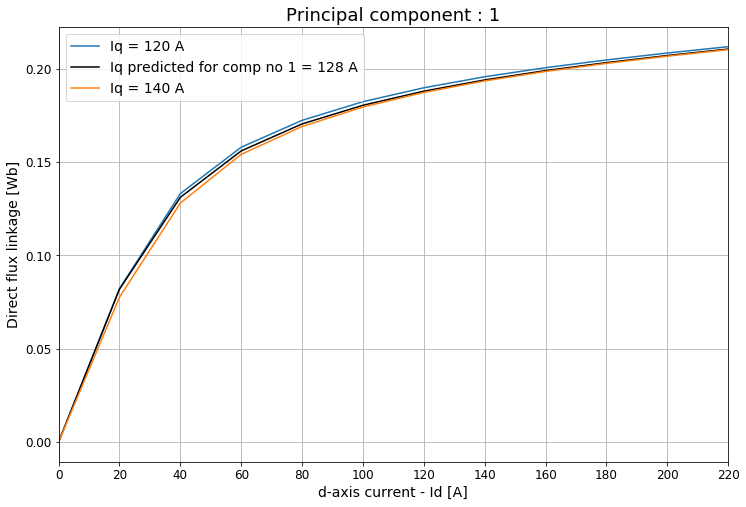

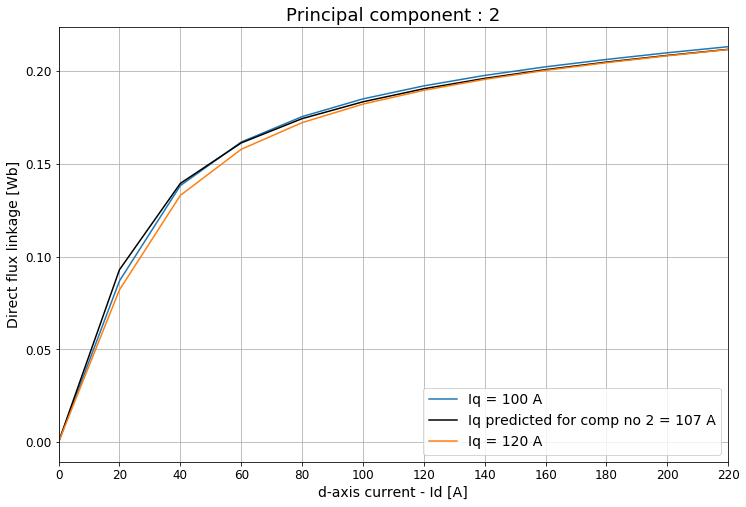

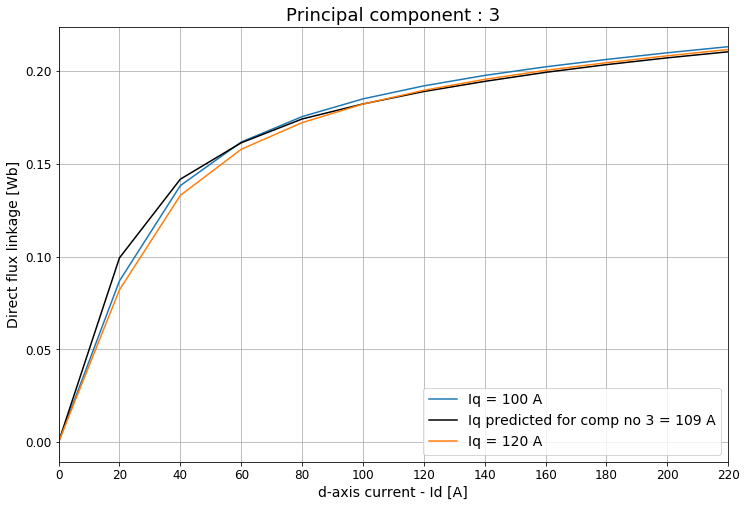

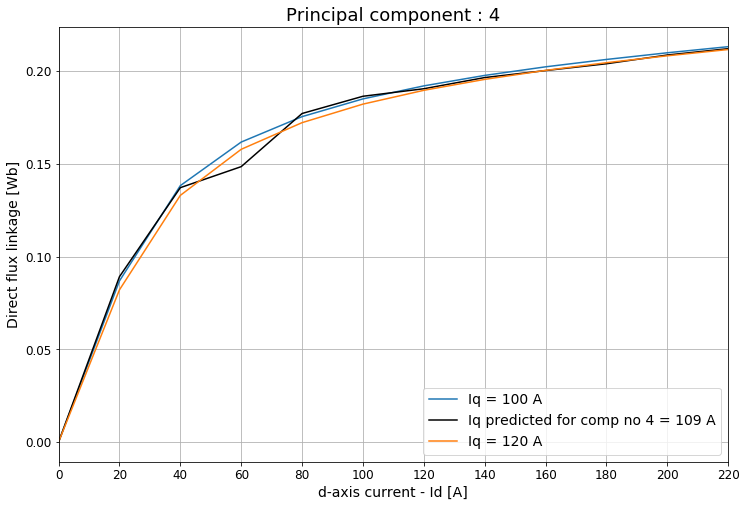

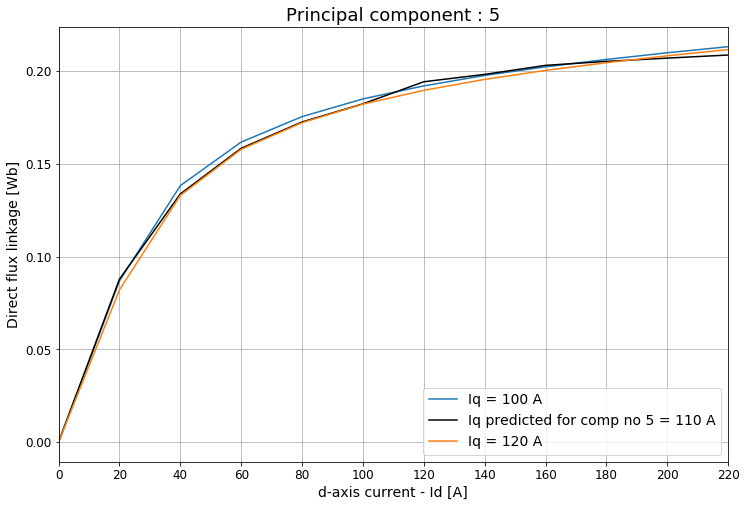

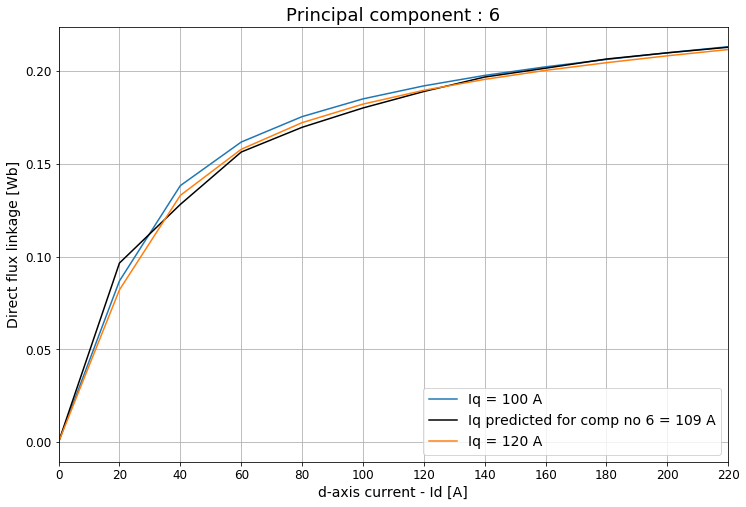

TypeError: 'numpy.ndarray' object is not callable

In [8]:
#
from sklearn.linear_model import Ridge

X = dfs.T
y = iqs

model = Ridge(fit_intercept=True, normalize=True)
model.fit(X, y)

# best case 1, worst case -1, random prediction: 0
print('Regression train score: %.2f\n' % model.score(X, y))

components = pca_reduce_curves.components_
components = scaler.inverse_transform(components)

result = model.predict(components)
print('Predicted Iqs: ')
for i, pred in enumerate(result):
    print('PCA_comp %d <=> IQ= %d' % (i, round(pred)))


#find upper and lower Iq curve
def border_curves(curve, interval):
    left = max([i for i in interval if i < curve])
    right = min([i for i in interval if i > curve])

    ## return index of left/right
    return interval.index(left), interval.index(right)


plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

top = 0
xAxis = list(range(0, 220, 20))

#data for csv
ridge_for_csv = [[] for i in range(len(result))]


for comp in components:    
    pred_iq = model.predict(comp.reshape(1, -1))
    left, right = border_curves(pred_iq, iqs)
    plt.title('Principal component : %d' % (top+1),fontsize=18)
    plt.plot(ids, dfs[:, left], label='Iq = %d A' % iqs[left])
    plt.plot(
        ids,
        components[top],
        color='black',
        label='Iq predicted for comp no %d = %d A' % (top + 1, pred_iq))
    plt.plot(ids, dfs[:, right], label='Iq = %d A' % iqs[right])
    plt.legend(fontsize=14)
    plt.xlabel(xLabel, fontsize = 14)
    plt.ylabel(yLabel, fontsize = 14)
    plt.xticks(list(range(0, 240, 20)))
    plt.xlim(0, 220)
    plt.grid()
    plt.savefig('PCA_comp{}_Ridge.png'.format(top+1), dpi = 220)
    plt.show()
    
    # prepare data for csv
    
    ridge_for_csv[top].append(round(pred_iq[0]))
    ridge_for_csv[top].append(iqs[left])
    ridge_for_csv[top].append(iqs[right])
    
    top += 1

# save to csv
df_ridge_to_csv_curves = df(data = ridge_for_csv)
df_ridge_to_csv_curves.to_csv('RidgePcaCurves.csv')
print(df_ridge_to_csv_curves)
# print(ridge_for_csv)


#  PCA to reduce the number of defining point  (ids from Ox axis)

    
Ideas:
 - Reduce the number of points, using PCA
 - Pt. reconstructie:
     - Spline pe nr redus de puncte
     - Loss intre Spline si curbele initiale
     
 


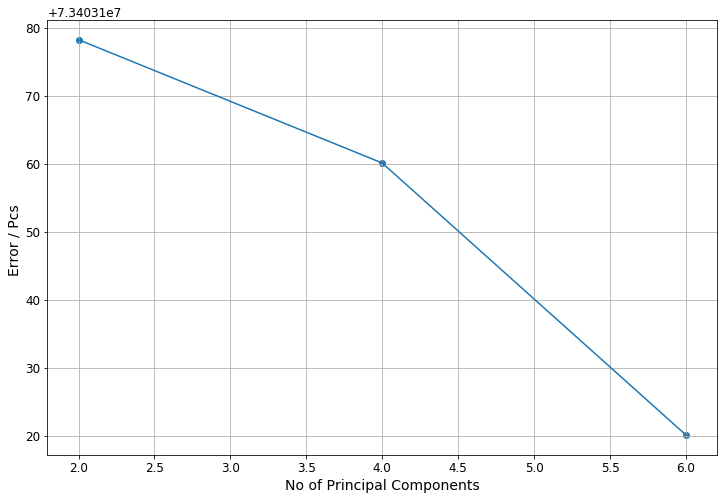

In [9]:
#
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing

#INITIALIZE THE TABLE 
headers =[ 'PCs' ] + ['Iq %s'%id for id in ids] 
rows    = []

#preprocess the data
flux = dfs.T
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(flux)

curve_indices = list(range(12))    
no_of_comps = [2,4,6]

error_per_PCs = np.zeros(shape = len(no_of_comps))
error_idx = 0

for comp in no_of_comps:
    
    row = [comp]
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    
    for curve in curve_indices:
    #spline for the reduced no of points
        x= ids
        y = dfs[:,curve]

        tck = interpolate.splrep(x, y, s=0)
        x_spline = np.linspace(ids.min(), ids.max(), 200)
        y_spline = interpolate.splev(x_spline, tck, der=0)
                                     
        x_new = np.linspace(projected_unscaled.min(), projected_unscaled.max(), 200)
        projected_baseline = interpolate.splev(x_new, tck, der=0)
        
        error = ((y_spline - projected_baseline) ** 2).sum()
        error = error.astype(np.float64) * (10 ** 6)
        row.append(error)
        error_per_PCs[error_idx]+=error
    error_idx+=1
    rows.append(row)
      
    plt.clf()
    plt.rcParams["figure.figsize"] = [12,8]
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    
    components = pca_reduce_points.components_
    components = scaler.inverse_transform(components)
    

    headers_PC =[ 'Idx of PC' ] + ['Id %s'%id for id in ids] 
    rows_PC    = []
    i = 1
    for component in pca_reduce_points.components_:
        row_PC = [i]
        for value in component:
            row_PC.append(value)
        i+=1
        rows_PC.append(row_PC)
        
#visualize the errors per PCs
# plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.xlabel('No of Principal Components', fontsize = 14)
plt.ylabel('Error / Pcs ', fontsize = 14)
plt.scatter(no_of_comps, error_per_PCs)
plt.plot(no_of_comps, error_per_PCs)
plt.grid()
plt.savefig('errorsPCSPoints.png', dpi = 200)
plt.show()
    
    
# print PC meaning   
# print ("Meaning of the %d components(Weights of each Id from OX axis)"  %comp)
# table_PC = plotTable(headers=headers_PC, rows=rows_PC, column_width=True, precision=5)
# print(table_PC)

# print errors in table    
# print('Loss ( sum squared error * 10 ^ 6)')
# table = plotTable(headers=headers, rows=rows, column_width=True, precision=4)
# print(table)
# print(error_per_PCs)

# Ridge for PCA reducing points no - reducing Ids from OX


In [10]:
#
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = dfs.T
y = list(ids)

model = Ridge(fit_intercept=True, normalize=True)
model.fit(X, y)

# best case 1, worst case -1, random prediction: 0
print('Regression train score: %.2f\n' % model.score(X, y))

components = pca_reduce_points.components_
components = scaler.inverse_transform(components)

#find upper and lower Iq curve
def border_curves(curve, interval):
    left = max([i for i in interval if i < curve])
    right = min([i for i in interval if i > curve])

    ## return index of left/right
    return interval.index(left), interval.index(right)

result = model.predict(components)
print('Predicted Ids (Ox axis coordinates): ')
csv_data = [[] for i in range(len(result))]
for i, pred in enumerate(result):
    left, right = border_curves(round(pred), y)
    print('PCA_comp %d <=> Id= %d A between (%d A, %d A)' % (i, round(pred), y[left], y[right]))
    csv_data[i].append(round(pred))
    csv_data[i].append(y[left])
    csv_data[i].append(y[right])

df_pred = df(data= csv_data)
df_pred.to_csv('RidgePcaPoints.csv')


Regression train score: 0.99

Predicted Ids (Ox axis coordinates): 
PCA_comp 0 <=> Id= 91 A between (80 A, 100 A)
PCA_comp 1 <=> Id= 113 A between (100 A, 120 A)
PCA_comp 2 <=> Id= 110 A between (100 A, 120 A)
PCA_comp 3 <=> Id= 110 A between (100 A, 120 A)
PCA_comp 4 <=> Id= 110 A between (100 A, 120 A)
PCA_comp 5 <=> Id= 110 A between (100 A, 120 A)


# Det Nr. Minim puncte  generatoare - Cubic spline interpolation

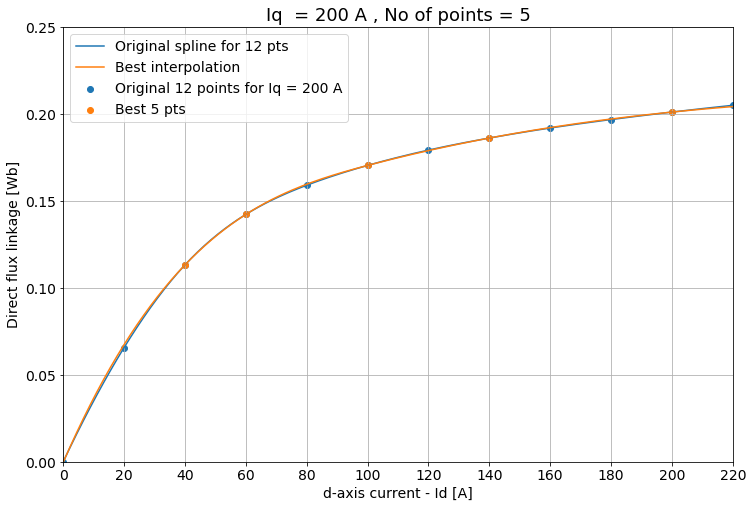

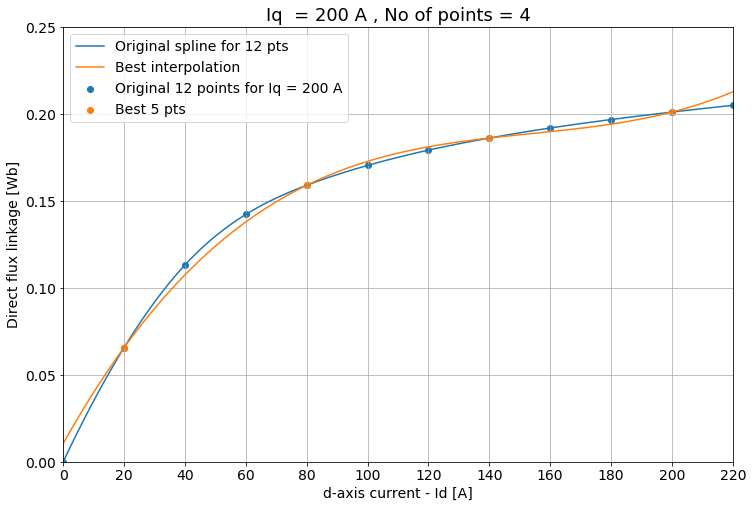

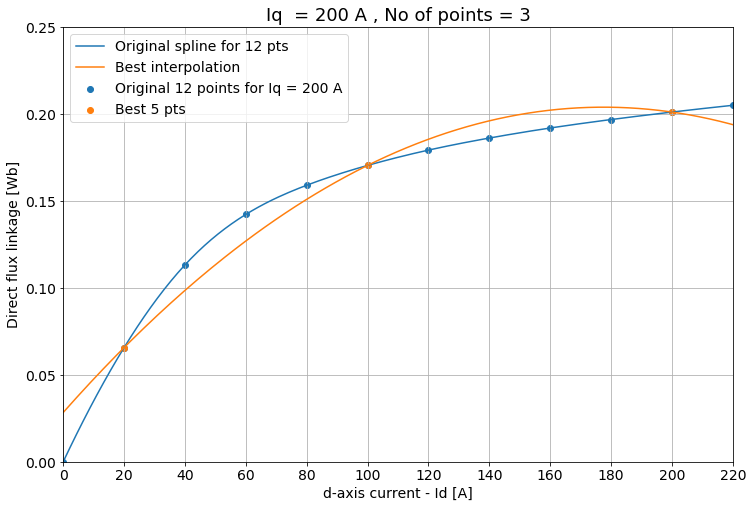

        1     2      3      4      5
220  40.0  60.0  100.0  180.0  200.0
200  40.0  60.0  100.0  140.0  200.0
180   0.0  60.0  100.0  160.0  200.0
160  40.0  60.0   80.0  160.0  200.0
140   0.0  60.0   80.0  160.0  200.0
120   0.0  20.0   80.0  160.0  200.0
100   0.0  20.0   80.0  140.0  200.0
80   20.0  40.0   80.0  160.0  200.0
60    0.0  40.0   60.0  160.0  200.0
40    0.0  40.0   60.0   80.0  200.0
20    0.0  40.0   60.0  120.0  160.0
0     0.0  40.0   60.0  140.0  200.0


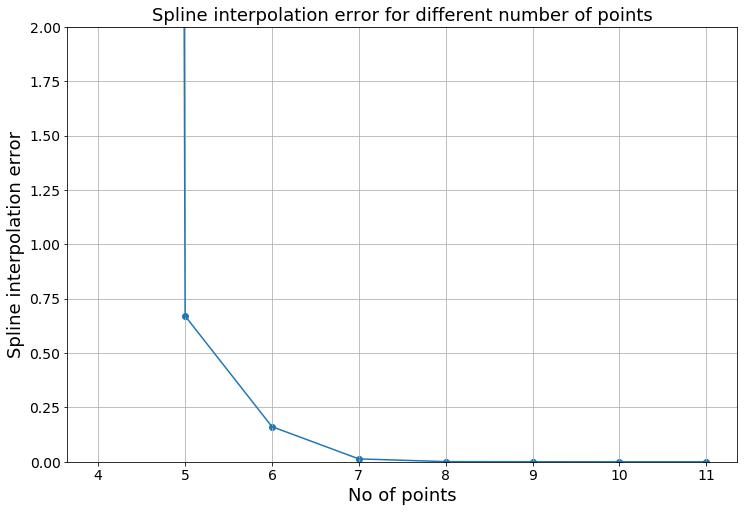

In [11]:
#cubic spline interpolation

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

curve_indices = list(range(0, 12)) 
curves_for_plot = [1]# list(range(1, 13,2))
pts_for_plot = [5,4,3]

# try interpolating with only 10, 9, 8 ... 4, 3 points
sub_points_num  = list(range(len(ids)-1, 2, -1))

headers = ['%s' %Is] + ['pts num: %d' % pts for pts in sub_points_num] + ['    Best 5 Points   ']
rows = []
x_best_5_pts = []
y_best_5_pts = []

#define total error per no of points
total_error_per_points_num = np.zeros(shape = 12)

for curve in curve_indices: #pentru fiecare curba Iq
    y = dfs[:, curve] #iau fluxurile corespunzatoare
    x = ids #iau id-urile
        
    tck = interpolate.splrep(x, y, s=0) #face spline pe toate cele 12 puncte
    x_new = np.linspace(min(x), max(x), 200)
        
    # baseline = y values obtained when interpolating with all ground truth points
    baseline = interpolate.splev(x_new, tck, der=0)
    
    row = ['%s %d' % (Is, iqs[curve])]
    best_5_points =[]
   
    for points_num in sub_points_num:
        # store best configuration
        best_pts     = (x, y)
        best_interp  = (x_new, baseline)
        best_error   = sys.float_info.max
        best_err_gr  = sys.float_info.max
    
        sub_points_sets = itertools.combinations(range(len(ids)), points_num)
        for pts in sub_points_sets:
            pts = list(pts)
            x_     = x[pts]
            y_     = y[pts]
          
            if points_num == 3:
                tck_   = interpolate.splrep(x_, y_, s=0, k=2)
                y_new_ = interpolate.splev(x_new, tck_, der=0) 
            else:
                tck_   = interpolate.splrep(x_, y_, s=0)
                y_new_ = interpolate.splev(x_new, tck_) 
        
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < best_error:
                best_error  = error
                best_pts    = (x_, y_) # best points from combination
                best_interp = (x_new, y_new_) # best points from interpolation
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr = sum_squared_error(y, gr_interp)
        
        if points_num == 5:
            best_5_points = best_pts[0]
            x_best_5_pts.append(best_pts[0])#to be used for linear interp
            y_best_5_pts.append(best_pts[1])#to be used for linear interp
            
        row.append(best_err_gr)
        total_error_per_points_num[points_num] += best_err_gr
        
      
        if curve in curves_for_plot and points_num in pts_for_plot:
            plt.clf()
            plt.rcParams["figure.figsize"] = [12, 8]
            plt.rcParams['xtick.labelsize']=14
            plt.rcParams['ytick.labelsize']=14
            plt.scatter(x, y, label='Original 12 points for Iq = %d A'%iqs[curve])
            plt.plot(x_new, baseline, label='Original spline for 12 pts')
            plt.scatter(best_pts[0], best_pts[1], label='Best 5 pts')
            plt.plot(best_interp[0], best_interp[1], label='Best interpolation')

            plt.ylim([0, 0.25])
            plt.xlim([0, 220])
            plt.xticks(ids)
            plt.xlabel(xLabel, fontsize = 14)
            plt.ylabel(yLabel, fontsize = 14)
           

            plt.legend(loc='best', fontsize = 14)
            plt.title('%s = %d A , No of points = %d' % (Is,iqs[curve], points_num),fontsize=18)
            plt.grid()
            plt.savefig('Points_num{}for Iq={}.png'.format(points_num, iqs[curve]))
            plt.show()
    
    row.append(best_5_points)
    rows.append(row)

#tabel csv for best_5_points
df_best_5_points = df(data = x_best_5_pts,
                      index = iqs,
                      columns = list(range(1,6))                                       
                     )
print(df_best_5_points)
df_best_5_points.to_csv('best_5_points.csv')
    
    
#plotting the errors
    
x_axis = list(range(4,12))
plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

plt.title('Spline interpolation error for different number of points',fontsize=18)
plt.scatter(x_axis,total_error_per_points_num[4:12]/12)
plt.plot(x_axis,total_error_per_points_num[4:12]/12)
plt.xlabel('No of points',fontsize=18)
plt.ylabel('Spline interpolation error',fontsize=18)
plt.ylim([0,2])
plt.grid()
plt.savefig('interp_error_Points_graphic.png', dpi = 200)
plt.show()

    

# print('Interpolation error ( sum squared error * 10 ^ 6)')
# table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
# print(table)


# Det. nr minim de curbe generatoare Iq  - Linear and Spline interpolation

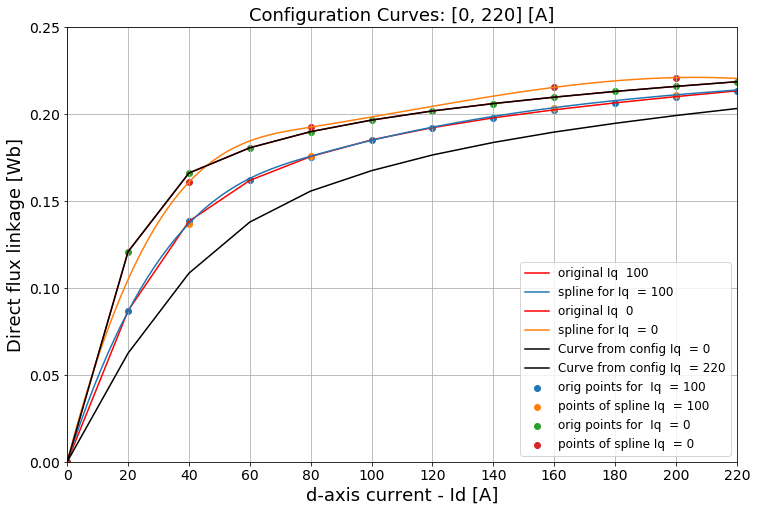

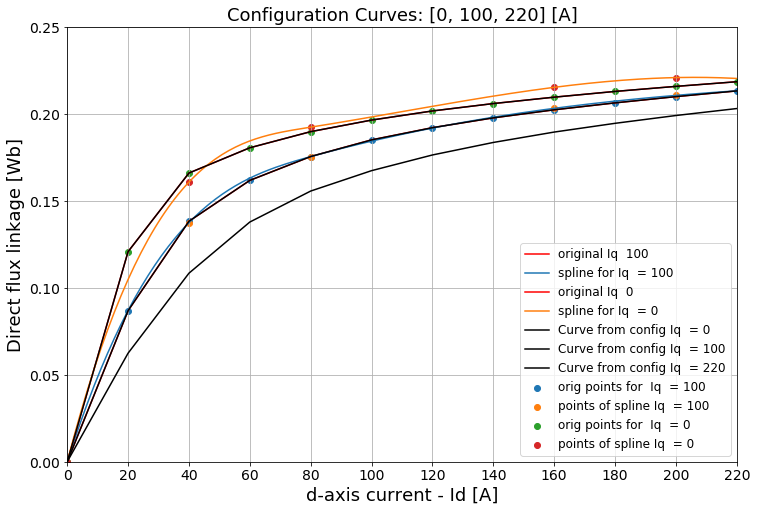

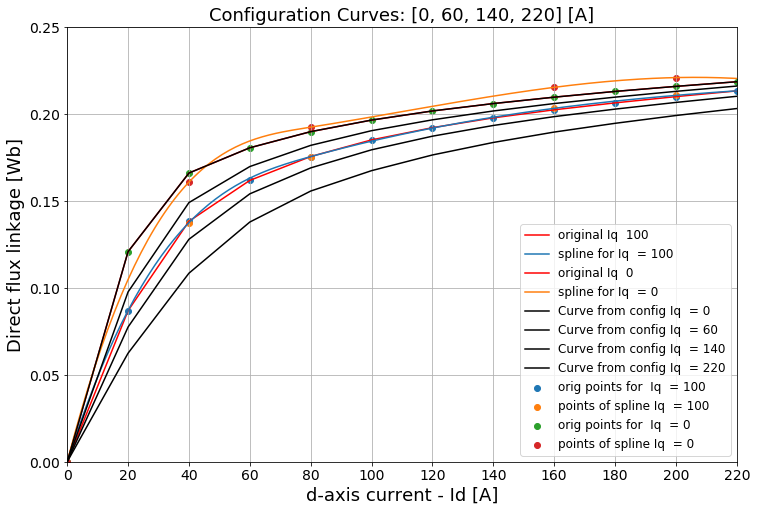

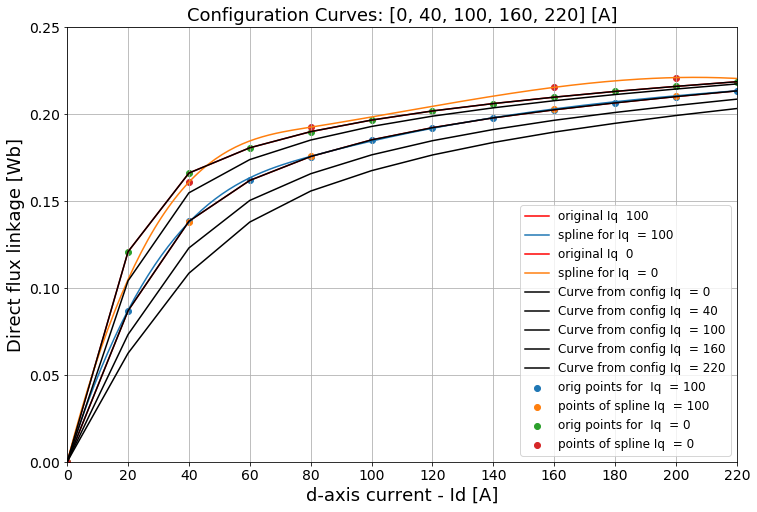

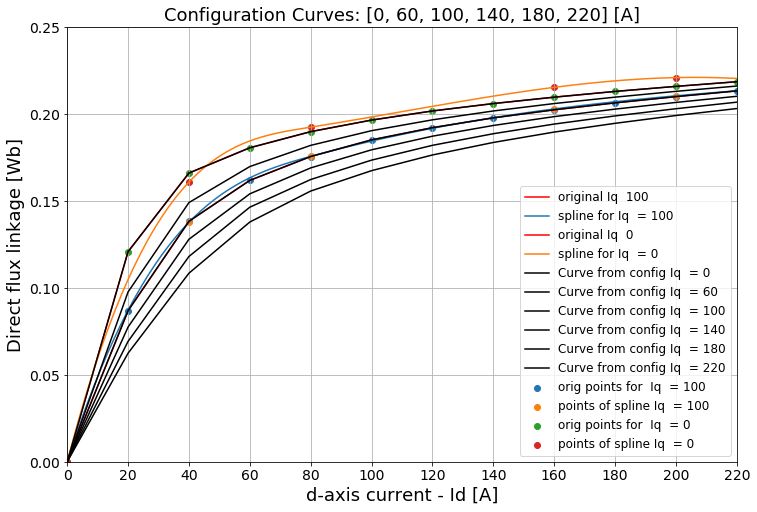

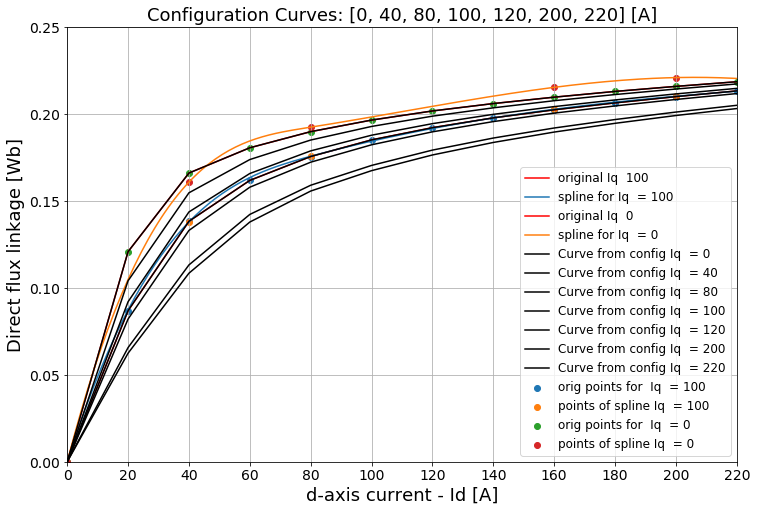

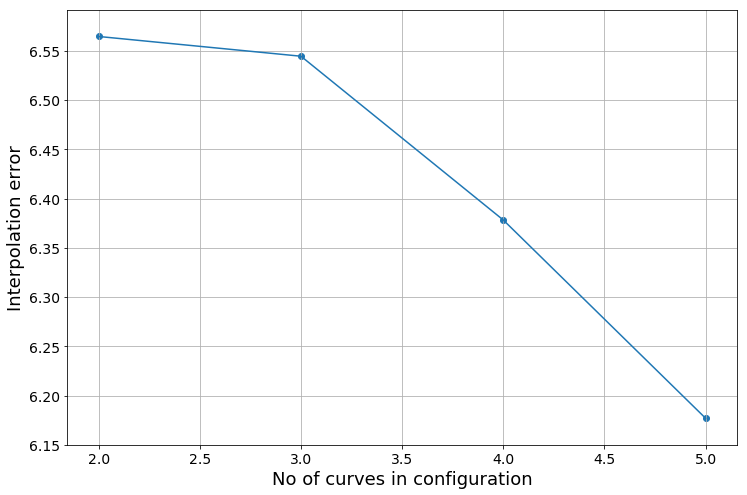

In [12]:
#
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
import numpy as np

best_points = [0., 40., 80., 160., 200.]
best_indices = [0,2,4,8,10] #indices of best-points
all_curves = list(range(12))
curves_for_plot = [11,6]

plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14


config_curves = [[11,0],[11,6,0],[11,8,4,0],[11,9,6,3,0],[11,8,6,4,2,0],[11,9,7,6,5,1,0]]
error_per_config = np.zeros(shape = len(config_curves))

# headers = ['%s' %Is] + ['no of curves: %d' % len(nr)for nr in config_curves]+['best no of curves']+['######### best config #########']
headers = ['######### Configuration ##########'] +['   Iq %d   ' % iqs[index] for index in all_curves] + ['error_per_config']
rows    = []

#define errors per curve in each config
error_per_curve = np.zeros(shape=(len(all_curves),len(config_curves)))

#define total error per config
error_per_config = np.zeros(shape = len(config_curves))

# flux pt best_points
def flux_for_curves_config(curves_config_indices):
    flux = [[] for i in range(12)]
    for curve in curves_config_indices:
        for idx in best_indices:
            flux[curve].append(dfs[idx][curve])
    return flux    

#incadrez curba intre doua curbe din config

def border_curves(curve, interval):
    pos = 0
    for id in interval:
        if iqs[curve] > iqs[id]:
            pos+=1
        else:
            if iqs[curve] == iqs[id]:
                if pos+1 == len(interval):
                    return pos, pos-1
                else:
                    return pos, pos+1
         
    return pos-1, pos 

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

for idx in range(len(config_curves)): #iau o configuratie
    indices = config_curves[idx]
    row =[[iqs[i] for i in indices]]
  
    for curve in all_curves: #pt fiecare curba
            
        start, end = border_curves(curve, indices)  #gasesc curbele care imi incadreaza curba de aproximat
        flux = flux_for_curves_config([start, end]) # retin fluxurile pentru curbele din config
       
        #interpolare liniara                       
        
        alpha = 1-((iqs[curve]-iqs[start])/(iqs[end]-iqs[start]))
             
        flux_approx = []
        for i in range(5):
            flux_approx.append(alpha * flux[start][i] + (1-alpha)*flux[end][i])
        
        ##Spline##
        
        #plotez cu toate cele 12 pcte
        y = dfs[:, curve] #iau fluxurile corespunzatoare
        x = ids #iau Id-urile

        tck = interpolate.splrep(x, y, s=0) #fac spline pe toate cele 12 puncte
        x_new = np.linspace(min(x), max(x), 200) #creez mai multe puncte

        # baseline = y values obtained when interpolating with all ground truth points
        baseline = interpolate.splev(x_new, tck, der=0) 
              
        # interpolate in best x points
        x_     = best_points
        y_     = flux_approx
        tck_   = interpolate.splrep(x_, y_, s=0)
        y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
      # error -- difference between baseline interp curve and current one
        error = sum_squared_error(baseline, y_new_)
           
#         print('%s: %d, curves num: %d' % (Is,iqs[curve], len(indices)))
        
        if curve in curves_for_plot:
            
#             color=next(ax._get_lines.prop_cycler)['color']
            plt.scatter(x, y, label='orig points for  %s = %d' %(Is, iqs[curve]))
            plt.plot(x, y, label='original %s %d' %(Is, iqs[curve]), color = 'red')
            plt.scatter(x_, y_, label='points of spline %s = %d' %(Is, iqs[curve]))
            plt.plot(x_new, y_new_, label='spline for %s = %d' %(Is, iqs[curve]))

            plt.ylim([0, 0.25])
            plt.xlim([0, 220])
            plt.xticks(ids)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
            plt.legend(loc='best')
            plt.title('Configuration Curves: %s [A]'%[iqs[i] for i in indices],fontsize=18)
            
           
        error_per_curve[curve][idx] = error
        error_per_config[idx]+=error
        
        row.append(error)
         
    row.append(error_per_config[idx]/12)
    
    rows.append(row) 
    
    
    for i in indices:
        df = dfs[:, i]
        plt.plot(ids, df, label='Curve from config %s = %d' %(Is,iqs[i]), color = 'black')
#         plt.scatter(best_points, [dfs[j][i] for j in best_indices], color = 'black')
        plt.ylim([0, 0.25])
        plt.xlim([0, 220])
        plt.xticks(ids)
        plt.xlabel(xLabel,fontsize=18)
        plt.ylabel(yLabel,fontsize=18)
        plt.legend(loc='best',fontsize=12)
    plt.grid()
    plt.savefig('{}curvesConfig.png'.format(len(indices)),dpi = 200)
    plt.show()



# print('Interpolation error ( sum squared error * 10 ^ 6)')
# table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
# print(table)


#Plotting the interpolation error

plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

plt.scatter([2,3,4,5],error_per_config[0:4]/12)
plt.plot([2,3,4,5], error_per_config[0:4]/12)
plt.xlabel('No of curves in configuration',fontsize=18)
plt.ylabel('Interpolation error',fontsize=18)
plt.grid()
plt.savefig('interp_error_Curves_graphic.png', dpi = 200)
plt.show()


# Curve fitting - elementary functions

In [ ]:
# # approximate de curve with different elementary functions

# def func_ord_7(x, h ,g, f, e, a, b, c, d):
#     return h * (x ** 7) + g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_6(x, g, f, e, a, b, c, d):
#     return g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_5(x, f, e, a, b, c, d):
#     return f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_4(x, e, a, b, c, d):
#     return e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_3(x, a, b, c, d):
#     return a * (x**3) + b * (x ** 2) + c * x + d

# def func_ord_2(x, a, b, c):
#     return a * (x**2) + b * x  + c
  
# def plot_original(iq_idx):
#     df = dfs[:, iq_idx]    
#     # plot original points     
#     plt.plot(ids, df, label = 'original')#, color = 'black')
#     plt.scatter(ids, df, color = 'black')

# def plot_curve_iq(iq_idx, func, func_descr='', label='', plot=False):
#     df = dfs[:, iq_idx]    
#     # fit curve to points     
#     w, pcov = curve_fit(func, ids, df, )
    
#     # compute error
#     df_pred = func(ids, *w)
#     error = (1 / len(ids)) * sum((df_pred - df) ** 2)
    
#     # predict new points     
#     x = np.arange(0, 240, 20)
#     y_pred = func(x, *w)
    
#     if plot:
#         plt.plot(x, y_pred,label = label)
#         plt.scatter(x, y_pred)
#         plt.title(' %s error: %.8f' % (func_descr, error))
#         plt.ylim([0, 0.25])
#         plt.xlim([0, 220])
#         plt.xticks(ids)
#         plt.xlabel(xLabel)
#         plt.ylabel(yLabel)
#         #plt.grid()
#         #plt.show()
#     return error
        
# funcs = [
#     func_ord_7,
#     func_ord_6, 
#     func_ord_5, 
#     func_ord_4, 
#     func_ord_3, 
#     func_ord_2
# ]
# dex = {
#     func_ord_7 : 'y=f(x**7)',
#     func_ord_6 : 'y=f(x**6)',
#     func_ord_5 : 'y=f(x**5)', 
#     func_ord_4 : 'y=f(x**4)',
#     func_ord_3 : 'y=f(x**3)',
#     func_ord_2 : 'y=f(x**2)',
# }

# curve_indices = list(range(0, 12)) 
# curve_for_plot = [6]

# # Get current size
# #plt.rcParams["figure.figsize"] = [12, 8]
    
# headers = ['%s ' %Is] + [dex[func] for func in funcs]
# rows    = []

# for curve_idx in curve_indices:
#     row = ['%s: %d' % (Is,iqs[curve_idx])]
#     toPlot = curve_idx in curve_for_plot
#     for func in funcs:
#         error = plot_curve_iq(curve_idx, func, '%s: %d' % (Is, iqs[curve_idx]), dex[func], plot=toPlot)
#         row.append(error * 10000)
#     rows.append(row)
        
#     if toPlot:
#         plot_original(curve_idx)
#         plt.show()
# #     plt.grid()
# #     plt.legend(loc='best')

# table = plotTable(headers=headers, rows=rows, precision=3)
# print(table)